### Progenitors cells distribution

In [1]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import scipy
import matplotlib.pyplot as plt

In [2]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
timestamp = '20210429'
marker_genes_dir = "/home/jovyan/mount/gdrive/Pan_fetal/significant_genes/marker genes/"

In [3]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/widespread_immunopoiesis/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir


In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)
library(ggplot2)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Load annotations

In [6]:
org_colors = pd.read_csv('../../metadata/organ_colors.csv')
org_colors

,organ,color
0,YS,#0173b2
1,LI,#de8f05
2,BM,#029e73
3,TH,#d55e00
4,SP,#cc78bc
5,MLN,#ca9161
6,SK,#fbafe4
7,GU,#949494
8,KI,#ece133


In [7]:
anno_df = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.annotated.clean.csv".format(t=timestamp), index_col=0)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes["x"] = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
anno_df = anno_df[~anno_df.index.isin(mat_barcodes["x"])]

In [9]:
## Assignment to progenitos
import json
progenitor_groups = {
    'T_prog':["DN(early)_T","DN(Q)_T", "DN(P)_T"],
    'B_prog' :['PRE_PRO_B','PRO_B','LATE_PRO_B','LARGE_PRE_B','SMALL_PRE_B'],
    'MEM_prog' : ['MEMP', 'CYCLING_MEMP', 'MEP'],
    'MYE_prog' : ['CMP','DC_PROGENITOR','GMP','MOP','MYELOCYTE','PROMONOCYTE','PROMYELOCYTE']
    }

with open('../../metadata/progenitor_groups.json', 'w') as outfile:
    json.dump({k:list(v) for k,v in progenitor_groups.items()}, outfile)

In [10]:
progenitor_groups_rev = {x:g for g,a in progenitor_groups.items() for x in a}

### Plot progenitor distribution

In [11]:
prog_df = anno_df[anno_df['anno_lvl_2_final_clean'].isin(progenitor_groups_rev.keys())]
prog_df = prog_df[['organ', 'donor', 'anno_lvl_2_final_clean']]
prog_df['lineage'] = [progenitor_groups_rev[x] for x in prog_df.anno_lvl_2_final_clean]


In [37]:
%%R -i prog_df -i org_colors -i figdir -w 1200 -h 600
org_palette <- setNames(org_colors$color, org_colors$organ)

lineage_names <- list(
  'MEM_prog'="Megakaryocyte/\nErythroid lineage",
  'MYE_prog'="Myeloid\nlineage",
  'B_prog'="B cells\nlineage",
  'T_prog'="T cells\nlineage"
)

lineage_labeller <- function(variable,value){
  return(lineage_names[value])
}

prog_df <- prog_df %>%
    rename(celltype=anno_lvl_2_final_clean) %>%
     group_by(organ, donor, lineage) %>%
    summarise(n_cells=n()) %>%
    pivot_wider(id_cols=c(donor, organ), names_from=lineage, values_from=n_cells, values_fill=0) %>%
    pivot_longer(cols=unique(prog_df$lineage), values_to='n_cells', names_to="lineage") %>%
    mutate(organ=factor(organ, levels=c("YS", "LI", "BM","TH", "SP", "MLN","SK", "KI", "GU"))) %>%
    mutate(lineage=factor(lineage, levels=c("MEM_prog", "MYE_prog", "B_prog", "T_prog"))) %>%
    group_by(organ, lineage) %>%
    mutate(median_n_cells=median(n_cells)) %>%
    ungroup() 
#     %>%
#     group_by(lineage) %>%
#     mutate(order = dense_rank(median_n_cells))
    

`summarise()` has grouped output by 'organ', 'donor'. You can override using the `.groups` argument.


In [38]:
%%R
ranking_df <- prog_df %>%
    group_by(organ, lineage) %>%
    summarise(median_n_cells = first(median_n_cells)) %>%
    ungroup() %>%
    group_by(lineage) %>%
    mutate(order = row_number(median_n_cells)) %>%
    ungroup() 

`summarise()` has grouped output by 'organ'. You can override using the `.groups` argument.


Joining, by = c("organ", "lineage", "median_n_cells")


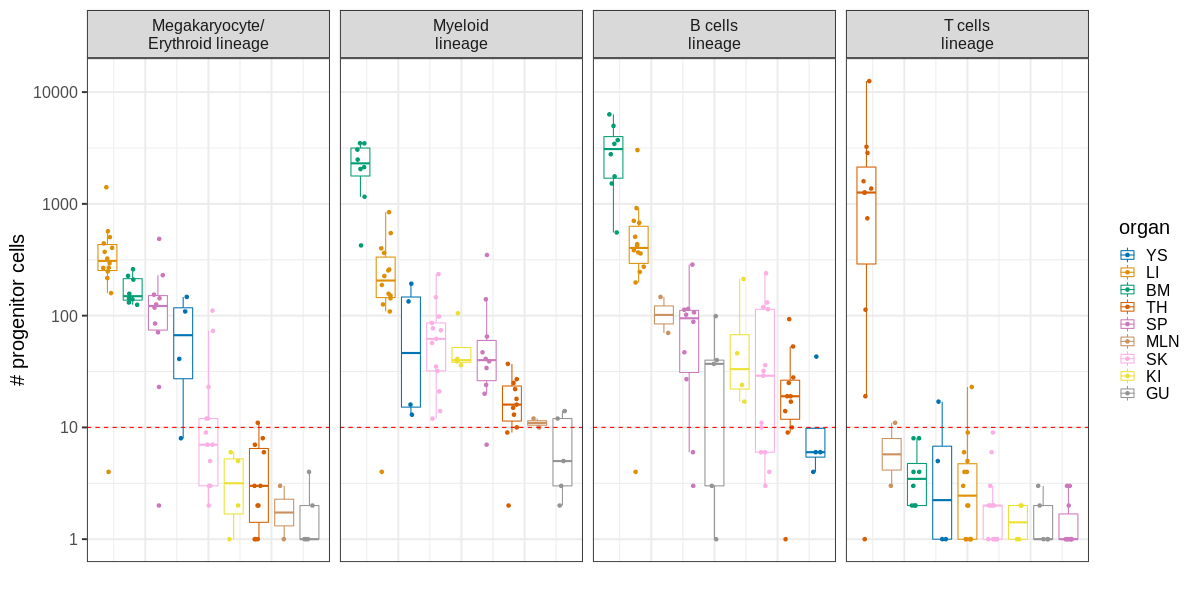

In [40]:
%%R -w 1200 -h 600
prog_df %>%
    left_join(ranking_df) %>%
    ggplot(aes(- order, n_cells+1, color=organ)) + 
    geom_boxplot(outlier.alpha=0, varwidth=FALSE) + 
#     geom_point() +
    geom_jitter(height=0, width=0.2) +
    scale_y_log10() +
    scale_color_manual(values=org_palette) +
    facet_grid(.~lineage, scales='free', labeller=lineage_labeller) +
    theme_bw(base_size=20) +
    ylab("# progenitor cells") + xlab("") +
    geom_hline(linetype=2, color='red', yintercept=10) +
    theme(axis.ticks.x=element_blank(), axis.text.x=element_blank()) +
    ggsave(paste0(figdir, "progenitor_cells_boxplot.pdf"), width=13, height=5)